In [2]:
using Images
using TestImages
using FileIO
using Colors
using ImageFeatures
using Formatting
# using Plots
using PyPlot
using DSP
using FixedPointNumbers
using Statistics

┌ Info: Recompiling stale cache file /home/luibo/.julia/compiled/v1.2/ImageFeatures/JMzL1.ji for ImageFeatures [92ff4b2b-8094-53d3-b29d-97f740f06cef]
└ @ Base loading.jl:1187
┌ Warning: Package Distributions does not have Test in its dependencies:
│ - If you have Distributions checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Distributions
└ Loading Test into Distributions from project dependency, future warnings for Distributions are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for ImageFeatures [92ff4b2b-8094-53d3-b29d-97f740f06cef]
│   exception = ErrorException("Required dependency Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] failed to load from a cache file.")
└ @ Base loading.jl:972
┌ Info: Recompiling stale cache file /home/luibo/.julia/compiled/v1.2/Distributions/xI

In [3]:
function backwardTransform(algo, M, P, outSize=nothing)
  M = inv(M)
  rows, cols = size(P)
  if outSize == nothing
    outSize = size(P)
  end
  out = zeros(eltype(P), outSize)

  for index in CartesianIndices(out)
    y, x = Tuple(index)
    sourceIndex = M * [x; y; 1]
    sourceIndex ./= sourceIndex[end]
    x1, y1 = round.(Int32, sourceIndex)
    if (x1 < 1 || y1 < 1 || x1 > cols || y1 > rows)
      continue
    end
    out[index] = P[y1, x1]
  end
  out
end

function createProjectiveMatrix(points)
  if length(points) != 4
    error("Not correct number of point")
  end

  A = zeros(Int64, 2*length(points), 8)
  B = zeros(Int64, 2*length(points), 1)
  for i in 1:length(points)
    x, y, x1, y1 = points[i]
    A[2*i - 1,:] = [x y 1 0 0 0 -x*x1 -x1*y]
    A[2*i,:] = [0 0 0 x y 1 -x*y1 -y*y1]
    B[2*i - 1] = x1
    B[2*i] = y1
  end

  H = vcat(A\B, 1)
  reshape(H, (3,3))'
end

function projectiveTransform(picture, points, outSize)
  M = createProjectiveMatrix(points)
  backwardTransform("zero", M, picture, outSize)
end

projectiveTransform (generic function with 1 method)

In [4]:
function hough(img)
  rows, cols = size(img)
  D = round(Int32, sqrt(rows ^ 2 + cols ^ 2))
  rhos = -D:1:D
  thetas = deg2rad.(-90:1:90)

  A = zeros(Int32, length(rhos), length(thetas))
  sins, coss = sin.(thetas), cos.(thetas)
  
  for idx in CartesianIndices(img)
    if img[idx] == 0
      # 0 or false
      continue
    end

    y, x = Tuple(idx)
    for thetaIdx in 1:length(thetas)
      rho = x * coss[thetaIdx] + y * sins[thetaIdx]
      rho = round(Int32, rho)
      A[rho + D, thetaIdx] += 1
    end
  end
  
  rowsA, colsA = size(A)
  for idx in CartesianIndices(A)
    y, x = Tuple(idx)
    if x == 1 || y == 1 || x == colsA || y == rowsA
      continue
    end
    C = A[idx]
    C1 = (C < A[y - 1, x - 1]) || (C < A[y - 1, x])
    C2 = (C < A[y - 1, x + 1]) || (C < A[y, x + 1])
    C3 = (C < A[y + 1, x + 1]) || (C < A[y + 1, x])
    C4 = (C < A[y + 1, x - 1]) || (C < A[y, x - 1])
    if C1 || C2 || C3 || C4
      A[idx] = 0
    end
  end

  A, rhos, thetas
end

hough (generic function with 1 method)

In [5]:
gaussian_kernel = [
  1 4 6 4 1
  4 16 24 16 4
  6 24 36 24 6
  4 16 24 16 4
  1 4 6 4 1
] ./ 256

sobel_x_kernel = [
  -1 0 1
  -2 0 2
  -1 0 1
]
sobel_y_kernel = rotl90(sobel_x_kernel)

3×3 Array{Int64,2}:
  1   2   1
  0   0   0
 -1  -2  -1

In [35]:
img_file = "IPCV-TestImage/IMG_9056.JPG"
rm("output/$(img_file)", recursive=true, force=true)
mkpath("output/$(img_file)")

img = load(img_file)
A4size = (3508, 2480)
A4row, A4col = A4size
points = [
  [3060 492 1 1],
  [3257 2199 A4col 1],
  [536 970 A4col A4row],
  [978 2572 1 A4row]
]
img = projectiveTransform(img, points, A4size)

display(img)

img_gray = Float64.(Gray.(img))
sobel_x_kernel = Float64.(sobel_x_kernel)
sobel_y_kernel = Float64.(sobel_y_kernel)

img_blur = conv2(img_gray, gaussian_kernel)
img_edge_x = conv2(img_blur, sobel_x_kernel)
img_edge_y = conv2(img_blur, sobel_y_kernel)

img_edge = round.(Int32, sqrt.((img_edge_x .^ 2) .+ (img_edge_y .^ 2)))
img_edge[img_edge .> 0] .= 1

# img_canny = canny(img, (Percentile(90), Percentile(10)))
# display(img_canny)


img_bool = zeros(Bool, size(img_edge))
img_bool[img_edge .> 0] .= true
display(Gray.(img_edge))
display()

InexactError: InexactError: trunc(Int32, -3.439150402e9)

In [7]:
acc, rhos, thetas = hough(img_edge)
for i in 1:50
  r_idx, t_idx = Tuple(argmax(acc))
  acc[r_idx, t_idx] = 0
  display((rhos[r_idx], rad2deg(thetas[t_idx])))
end

(2482, 0.0)

(2484, 0.0)

(-5, -90.0)

(3, 90.0)

(-4, -90.0)

(2, 90.0)

(1079, -26.0)

(1068, -26.0)

(-6, -90.0)

(4, 90.0)

(-3, -90.0)

(1, 90.0)

(257, -17.0)

(533, 83.0)

(454, 83.0)

(2, 0.0)

(1013, 81.0)

(806, 82.0)

(1008, 81.0)

(721, 82.0)

(1325, 80.0)

(1320, 80.0)

(458, 83.0)

(544, -20.0)

(1553, 79.0)

(1558, 79.0)

(-3512, -90.0)

(3510, 90.0)

(-3513, -90.0)

(3511, 90.0)

(821, -23.0)

(723, 82.0)

(456, 83.0)

(1103, 81.0)

(1224, 80.0)

(259, -17.0)

(1070, -26.0)

(534, -21.0)

(518, -21.0)

(535, 83.0)

(230, -18.0)

(2339, 76.0)

(2344, 76.0)

(1802, 78.0)

(2064, 77.0)

(808, 82.0)

(1797, 78.0)

(1663, 79.0)

(2059, 77.0)

(1081, -26.0)

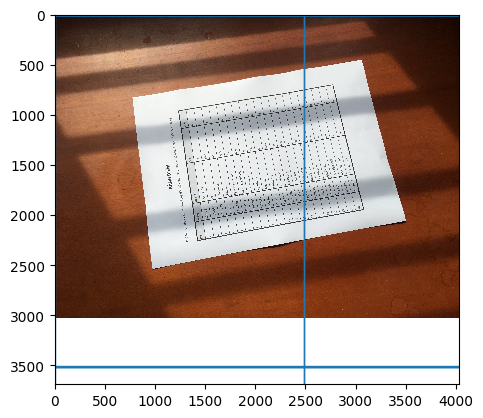

In [8]:
acc, rhos, thetas = hough(img_edge)
rows, cols = size(img)
my_dpi = 96

plt = PyPlot
# PyPlot.svg(true)
plt.figure(figsize=(cols/my_dpi, rows/my_dpi), dpi=my_dpi)

plot_img = plt.imread(img_file)
fig, ax = plt.subplots()
# fig = plt.figure(figsize=(cols/2, rows/2))
# fig.set_size_inches(cols,rows)

xs = []
ys = []

ax.imshow(plot_img)
while true
  r_idx, t_idx = Tuple(argmax(acc))
  if (acc[r_idx, t_idx] < 800)
    break
  end
  acc[r_idx, t_idx] = 0

  rho, theta = rhos[r_idx], thetas[t_idx]
  theta = rad2deg(theta)
  # display(theta)
  if (theta == 90 || theta == -90)
    y = rho / sind(theta)
    ax.axhline(y, linewidth=1)
    push!(ys,y)
  elseif (theta == 0)
    x = rho
    ax.axvline(x, linewidth=1)
    push!(xs,x)
  else
    continue
  end
end
savefig("output/$(img_file)/hough.svg", dpi=my_dpi * 20)

3-element Array{Any,1}:
    2
 2482
 2484

12-element Array{Any,1}:
    1.0
    2.0
    3.0
    3.0
    4.0
    4.0
    5.0
    6.0
 3510.0
 3511.0
 3512.0
 3513.0

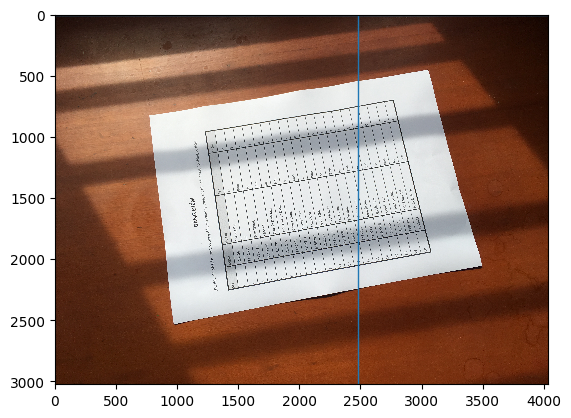

In [9]:
xs = sort(xs)
ys = sort(ys)

display(xs)
display(ys)

function get_arround(arr)
  out = Float64[]
  tmp = Float64[]
  last = 0
  for val in arr
    if last == 0
      last = val
      continue
    end
    push!(tmp, val)
    if abs(val - last) > 10
      # push!(out, round(Int32,mean(tmp)))
      push!(out, tmp[1])
      tmp = []
    end
    last = val
  end
  Int32.(out)
end

xss = get_arround(Float64.(xs))
yss = get_arround(Float64.(ys))
  
# display(xss)
# display(yss)
  
plt.figure(figsize=(cols/my_dpi, rows/my_dpi), dpi=my_dpi)
plot_img = plt.imread(img_file)
fig, ax = plt.subplots()
ax.imshow(plot_img)
for y in yss
  ax.axhline(y, linewidth=1)
end
for x in xss
  ax.axvline(x, linewidth=1)
end
savefig("output/$(img_file)/better_hough.svg", dpi=my_dpi * 20)

In [10]:
sub_imgs = []
for i in 4:length(xss)-1
  mkpath("output/$(img_file)/$(i-1)")
  # display((i, !(i in [3,4,5,7])))
#   if (!(i in [3,4,5,7,8]))
#     continue
#   end
  for j in 6:length(yss)-1
#     if j < 4
#       continue
#     end
    c = xss[i-1]:xss[i]
    r = yss[j-1]:yss[j]
    sub_img = img[r,c]
    push!(sub_imgs, sub_img)
    display(sub_img)
    # display("======================")
    save("output/$(img_file)/$(i-1)/$(j-1).png", sub_img)
  end
end

In [11]:
# sub_img = sub_imgs[28]
for sub_img in sub_imgs
  display(sub_img)
  sub_img_f = Float64.(Gray.(sub_img))
  gray_point = vec(sum(sub_img_f, dims=1))
  gray_maximum = maximum(gray_point)
  gray_point[gray_point .< 10] .= 0
  gray_point[abs.(gray_point .- gray_maximum) .< 10] .= gray_maximum

  # display(gray_point)
  plt.plot(gray_point)

  digit_start = 1
  digit_end = length(gray_point)
  slide = 0
  window_size = 0

  for (index, value) in enumerate(gray_point)
    if value == 0 || value == gray_maximum
      if window_size > 2
        digit_end = index
        break
      elseif slide == 1
        slide = 0
      end
      continue
    end
    if slide == 0
      digit_start = index - 1
      slide = 1
      window_size = 1
    elseif index - digit_start > 1
      digit_start = index
      window_size = 1
    end
    window_size += 1
  end

  if (digit_start < 11)
    digit_start = 11
  end
  display((digit_start, digit_end))
  display(sub_img[:, digit_start-10:digit_end])
end